In [ ]:
### tradin strategies ith multiple machine learning model

In [14]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn import linear_model
import xgboost
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm


In [5]:
pip install alpha_vantage

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas_datareader as pdr
from alpha_vantage.timeseries import TimeSeries

key = 'SJNDG3FXMS6F62L0'

ts = TimeSeries(key = key,output_format='pandas')

df, meta_data = ts.get_monthly_adjusted('TTM')

df

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount
date,,,,,,,
2023-05-12,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
2023-04-28,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
2023-03-31,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
2023-02-28,25.14,25.14,25.14,25.14,25.1400,0.0,0.0
2023-01-31,23.40,25.93,22.61,25.14,25.1400,32189809.0,0.0
...,...,...,...,...,...,...,...
2005-02-28,11.35,11.64,10.66,10.88,9.2084,4014900.0,0.0
2005-01-31,12.22,12.25,10.45,11.63,9.8431,5082700.0,0.0
2004-12-31,11.00,12.18,10.71,11.92,10.0886,7659800.0,0.0


Model building 

In [19]:
pip install --upgrade scikit-learn


   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.7 MB 3.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/10.7 MB 2.6 MB/s eta 0:00:04
   ----- ---------------------------------- 1.6/10.7 MB 2.5 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/10.7 MB 2.7 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/10.7 MB 2.7 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/10.7 MB 2.7 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/10.7 MB 2.8 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/10.7 MB 2.8 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/10.7 MB 2.8 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/10.7 MB 2.8 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/10.7 MB 1.8 MB/s eta 0:00:04
   -------------- ------------------------- 3.9/10.7 MB 1.8 MB/s eta 0:00:04
   ---

  You can safely remove it manually.


In [21]:
X=df.drop('5. adjusted close',axis=1)
y=df['5. adjusted close']

# y= np.diff(np.log(df['adjusted close'].value))
# y=np.append(y[0],y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Linear Regression
linear_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = linear_model.predict(sm.add_constant(X_test))
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
linear_r_squared = linear_model.rsquared
linear_adj_r_squared = linear_model.rsquared_adj

print("\nLinear Regression Model Summary:")
print("\nRMSE:",lr_rmse)
print("R-squared:", linear_r_squared)
print("Adjusted R-squared:", linear_adj_r_squared)


Linear Regression Model Summary:

RMSE: 0.6709314275144683
R-squared: 0.9963394873982309
Adjusted R-squared: 0.9962117950981692


Random Forest

In [27]:
X=df.drop('5. adjusted close',axis=1)
y=df['5. adjusted close']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

rf=RandomForestRegressor(n_estimators=100,
                        criterion='squared_error',
                        max_depth=3,
                        min_samples_split=2,
                        bootstrap=True,
                        random_state=42)

rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
rf_r2_score = r2_score(y_test, y_pred)
n= X_train.shape[0]
p=X_train.shape[1]
rf_adj_r2_score = 1-(1-rf_r2_score)*((n-1)/(n-p-1))

print("\nRandom Forest Model Summary:")
print("\nRmse:",rf_rmse)
print("R-squared:", rf_r2_score)
print("Adjusted R-squared:", rf_adj_r2_score)


Random Forest Model Summary:

Rmse: 1.1187201901062593
R-squared: 0.9882842616804087
Adjusted R-squared: 0.9878755731343765


XGBoost

In [30]:
X=df.drop('5. adjusted close',axis=1)
y=df['5. adjusted close']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

xgb = xgboost.XGBRegressor(booster='gbtree',objective='reg:squarederror')
param_grid = {'learning_rate':[0.01,0.05,0.1],
              'max_depth': [2,4,6],
              'n_estimators': [20,50,100,200]}

xgb_model = GridSearchCV(estimator=xgb, param_grid=param_grid,cv=5)
xgb_model.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [20, 50, 100, 200]})

#printitng the xgb model result

In [31]:
print(xgb_model.best_score_)
xg_params=xgb_model.best_params_
print('Best Params: ',xg_params)

0.9907440248273142
Best Params:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [32]:
top_param_model = xgb_model.best_estimator_

In [33]:

y_pred = top_param_model.predict(X_test)
xg_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
xgb_r2_score = r2_score(y_test, y_pred)
n = X_train.shape[0]
p = X_train.shape[1]
xgb_adj_r2_score = 1-(1-xgb_r2_score)*((n-1)/(n-p-1))

print("\nXGBoost Model Summary:")
print("\nRMSE:",xg_rmse)
print("R-squared:", xgb_r2_score)
print("Adjusted R-squared:", xgb_adj_r2_score)


XGBoost Model Summary:

RMSE: 0.7825177636209916
R-squared: 0.9942678820173237
Adjusted R-squared: 0.9940679244132768


In [49]:
from alpha_vantage.timeseries import TimeSeries
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Step 1: Alpha Vantage setup
api_key = 'SJNDG3FXMS6F62L0'  # your key
symbol = 'TTM'

ts = TimeSeries(key=api_key, output_format='pandas')
df, meta_data = ts.get_monthly_adjusted(symbol)

# Step 2: Prepare data
df = df.sort_index()  # Ensure it's in ascending order
df = df[['5. adjusted close']].rename(columns={'5. adjusted close': 'Adj Close'})
df.index = pd.to_datetime(df.index)

# Optional: Filter date range like in your original code
start_date = '2004-10-29'
end_date = '2023-05-12'
df = df.loc[start_date:end_date]

# Step 3: Format for SARIMAX
df = df.resample('M').mean().reset_index()
df = df.set_index('date')

# Step 4: SARIMAX model
SARIMA_model = SARIMAX(df['Adj Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
result = SARIMA_model.fit(disp=False)

# Output summary
print(result.summary())


C:\Users\mishr\AppData\Local\Temp\ipykernel_22504\4205406128.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').mean().reset_index()
C:\Users\mishr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\mishr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                  224
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -522.452
Date:                            Wed, 18 Jun 2025   AIC                           1054.904
Time:                                    20:23:56   BIC                           1071.663
Sample:                                10-31-2004   HQIC                          1061.678
                                     - 05-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1573      2.308      0.068      0.946      -4.367       4.681
ma.L1         -0.1869      2.288   

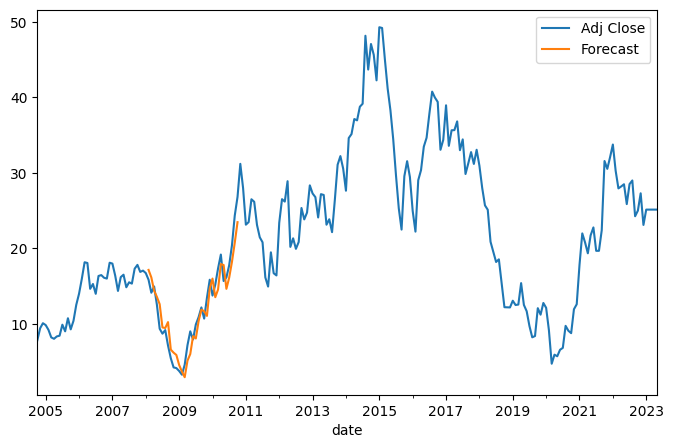

In [50]:

predicted = result.predict(start=40, end=72)
df["Forecast"] = result.predict(start=40, end=72)
df[["Adj Close","Forecast"]].plot(figsize = (8,5));

C:\Users\mishr\AppData\Local\Temp\ipykernel_22504\2262763715.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data=pd.concat([df,future_data])


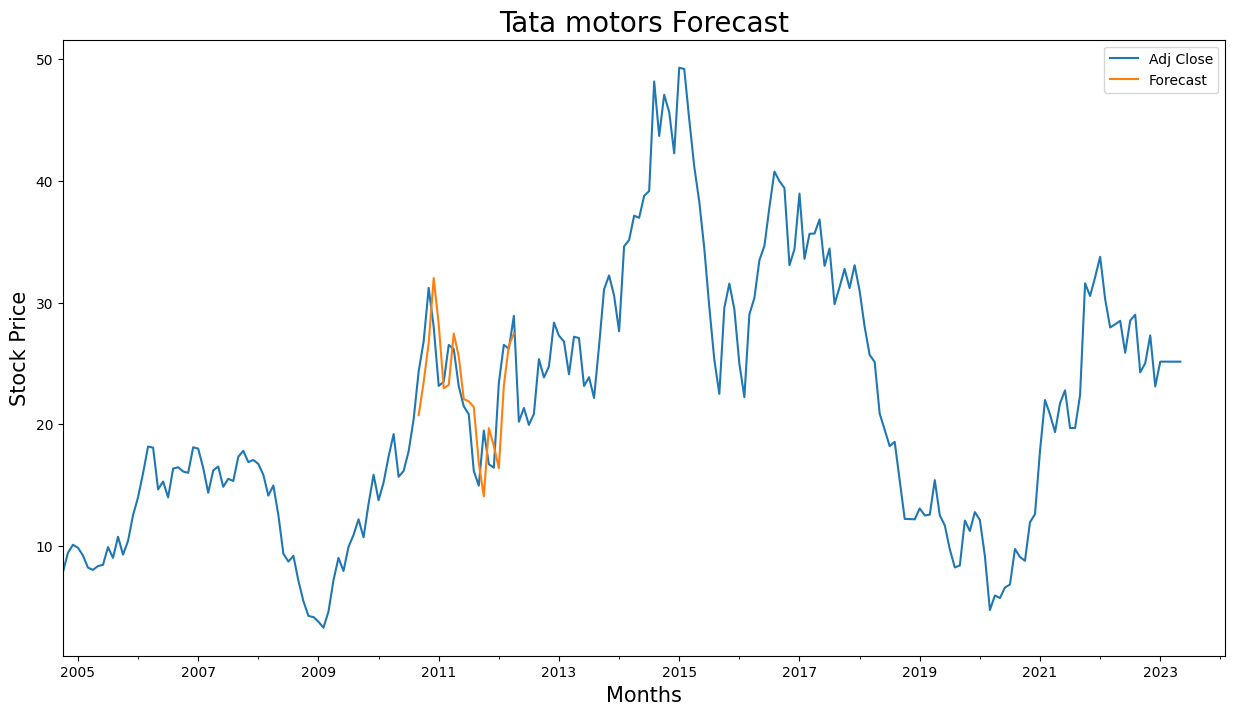

In [51]:
from pandas.tseries.offsets import DateOffset

future_dates = [df.index[-1] + DateOffset(months = x) for x in range(1,10)]
future_data = pd.DataFrame(index=future_dates,columns=df.columns)

final_data=pd.concat([df,future_data])
final_data.head()

# forecasting
final_data["Forecast"]=result.predict(start=71,end=90)

final_data["Adj Close"].plot()
final_data["Forecast"].plot(figsize = (15,8))
plt.title("Tata motors Forecast",size = 20)
plt.xlabel("Months",size=15)
plt.ylabel("Stock Price",size=15)
plt.legend();

C:\Users\mishr\AppData\Local\Temp\ipykernel_22504\1023332232.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=n_steps, freq='M')


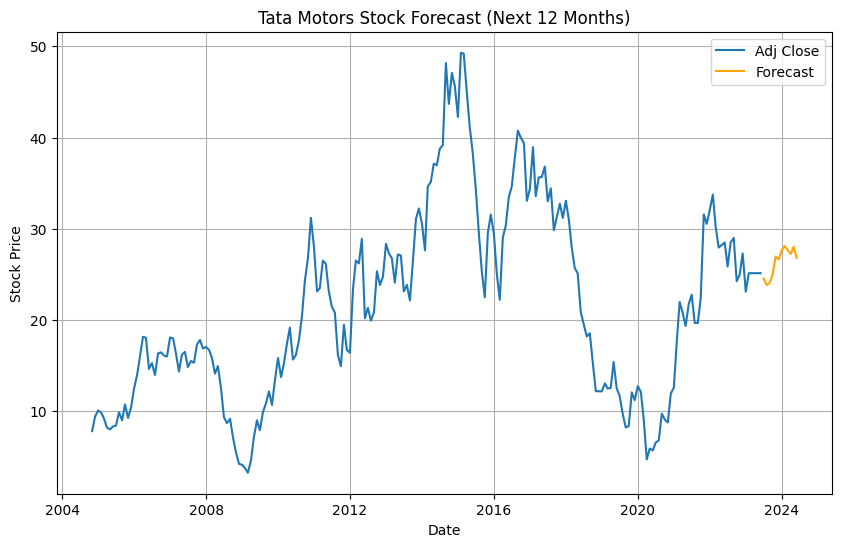

In [54]:
# Step 1: Forecast future values
n_steps = 12  # Forecast next 12 months
forecast = result.forecast(steps=n_steps)

# Step 2: Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=n_steps, freq='M')

# Step 3: Make a new DataFrame for future forecast
forecast_df = pd.DataFrame({'Forecast': forecast}, index=future_dates)

# Step 4: Plot actual + forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['Adj Close'], label='Adj Close')
plt.plot(forecast_df['Forecast'], label='Forecast', color='orange')
plt.title("Tata Motors Stock Forecast (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Trim actual to match length of predicted
actual = df['Adj Close'][-len(predicted):]

# Then calculate RMSE
sarimax_rmse = np.sqrt(mean_squared_error(actual, predicted))
print('RMSE of SARIMA model:', round(sarimax_rmse, 2))


RMSE of SARIMA model: 15.24


In [58]:

rmse = {'Linear Regression':lr_rmse,
        'Random Forest':rf_rmse,
        'XGBoost':xg_rmse,
        'Sarimax':sarimax_rmse}

model_rmse = pd.DataFrame.from_dict(rmse,orient='index')
model_rmse.index.name='Model'
model_rmse.rename(columns={model_rmse.columns[0]:'RMSE'})

,RMSE
Model,
Linear Regression,0.670931
Random Forest,1.118720
XGBoost,0.782518
Sarimax,15.236488
